#  Topic: Classification of Fetal Health using Cardiotocogram Data

*Abstract: Cardiotocographs are a novel and innovative way
to monitor fetal health, allowing healthcare profes-
sionals to take action to prevent infant mortality
rates. The project aims to classify the fetal health
outcomes by building a variety of multi-class clas-
sification models by training on the data extracted
from Cardiotocogram exams.*

**Import the libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import seaborn as sns

In [2]:
#Read the input data
data =  pd.read_csv('..//data//fetal_health.csv')

## 1. Exploratory Data Analysis

In [3]:
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,62,126,2,0,120,137,121,73,1,2
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,68,198,6,1,141,136,140,12,0,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,68,198,5,1,141,135,138,13,0,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,53,170,11,0,137,134,137,13,1,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,53,170,9,0,137,136,138,11,1,1


In [4]:
data.shape

(2126, 22)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   int64  
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   int64  
 8   mean_value_of_short_term_variability  

**a. Investigation of Missing Values**

<AxesSubplot:>

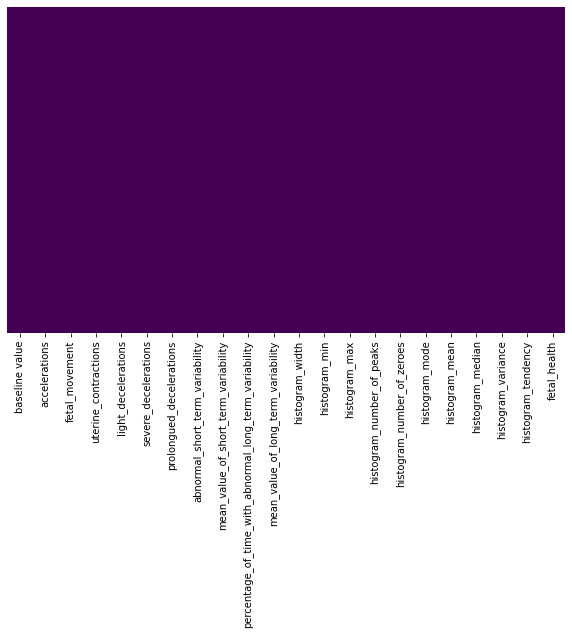

In [6]:
plt.figure(figsize=(10,6))
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

***Conclusion:*** *The heatmap indicates the data is well curated and has no missing values, this will make our model building process a lot easier*

**b. Plots to display relationship between Predictor and Response Variable and also identify the Outliers**

In [7]:
%matplotlib inline

In [8]:
#Select some predictor columns
box_plot_list = list(data.columns)
box_plot_list.remove('fetal_health')

In [9]:
#copy the existing df to a new df 
data_1 = data.copy()

#Replace the target variable values to its corresponding descriptions
data_1.replace({'fetal_health' : { 1 : 'Normal', 2 : 'Suspect', 3 : 'Pathological' }},inplace=True)

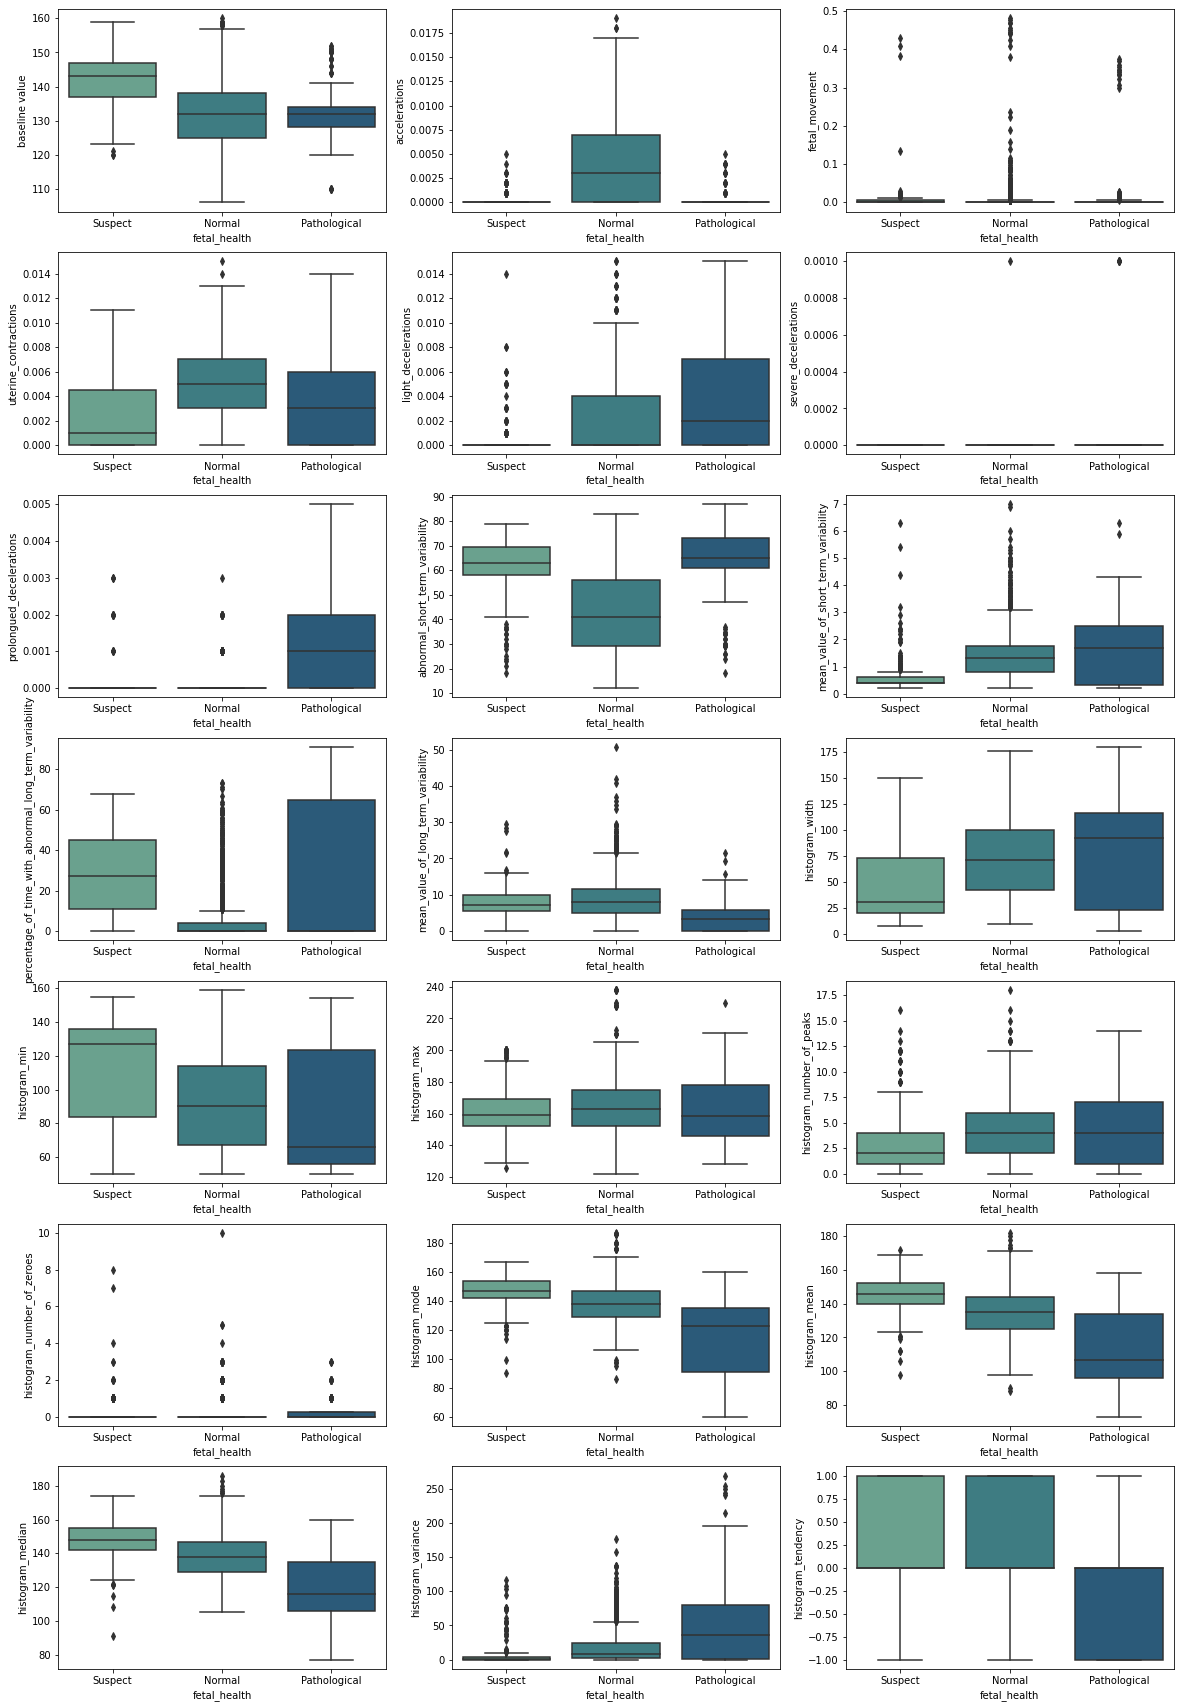

In [10]:
plt.figure(figsize=(20,35))
for i in range(1,len(box_plot_list)+1):
     plt.subplot(8, 3, i)
     sns.boxplot(x=data_1['fetal_health'], y = data_1[box_plot_list[i-1]], dodge= False, palette="crest") 

***Conclusion:*** *Some of the predictors contain significant number of outliers*

The identified outliers are: 

1) percentage_of_time_with_abnormal_long_term_variability

2) mean_value_of_short_term_variability

3) mean_value_of_long_term_variability

4) histogram_variance

In [11]:
outlier_list = ['percentage_of_time_with_abnormal_long_term_variability',
                'mean_value_of_short_term_variability',
                'mean_value_of_long_term_variability',
                'histogram_variance']

In [12]:
def remove_outlier(col, df):
    '''
    function to detect and remove the outliers. Considering 3 std outside the mean as an outlier
    '''
    lowerbound = col.mean() - 3 * col.std()
    upperbound = col.mean() + 3 * col.std()
    df1 = df[(col >= lowerbound) & (col <= upperbound) ]
    #print(type(df),type(df1))
    print(f'{df.shape[0]-df1.shape[0]} outliers removed from {col.name}')
    return df1

In [13]:
data_clean= data.copy()
for i in outlier_list:
    data_clean = remove_outlier(data_clean[i], data_clean)

59 outliers removed from percentage_of_time_with_abnormal_long_term_variability
33 outliers removed from mean_value_of_short_term_variability
30 outliers removed from mean_value_of_long_term_variability
43 outliers removed from histogram_variance


In [14]:
data_clean.shape

(1961, 22)

In [15]:
data_clean = data_clean.reset_index(drop=True)

**c. Correlation Analysis**

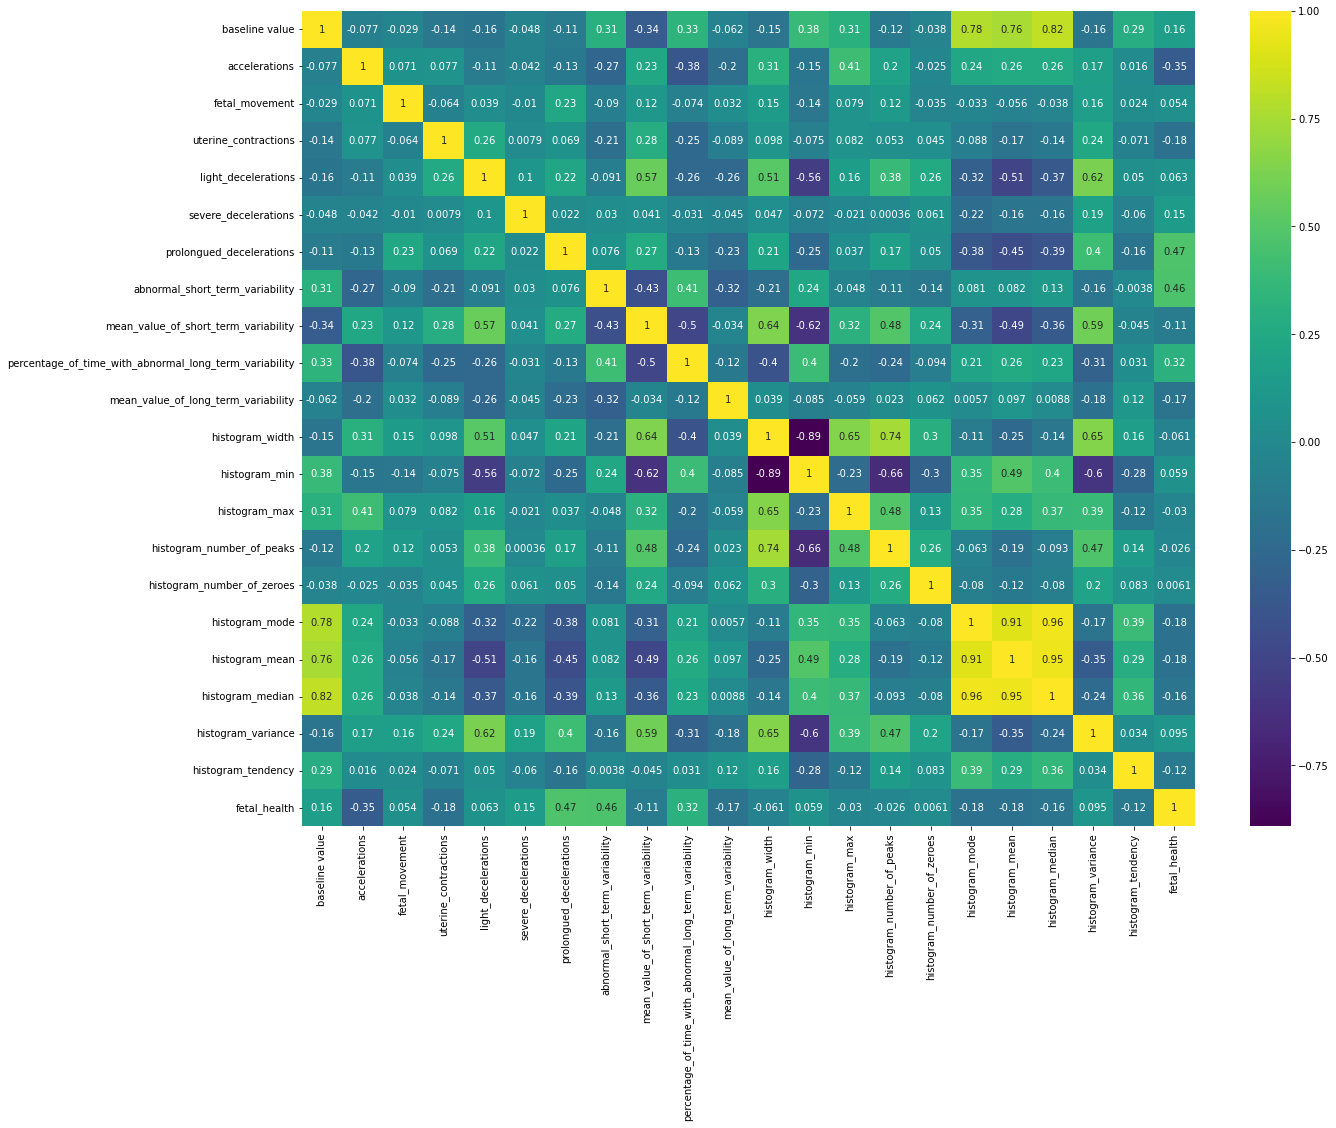

In [16]:
plt.figure(figsize=(20,15))
g = sns.heatmap(data_clean.corr(),annot = True, cmap='viridis')

***Conclusion:*** *There are some features that show high collinearity, we will drop these features*

In [17]:
data_clean.drop(['histogram_min','histogram_mode','histogram_median'],axis = 1,inplace=True)

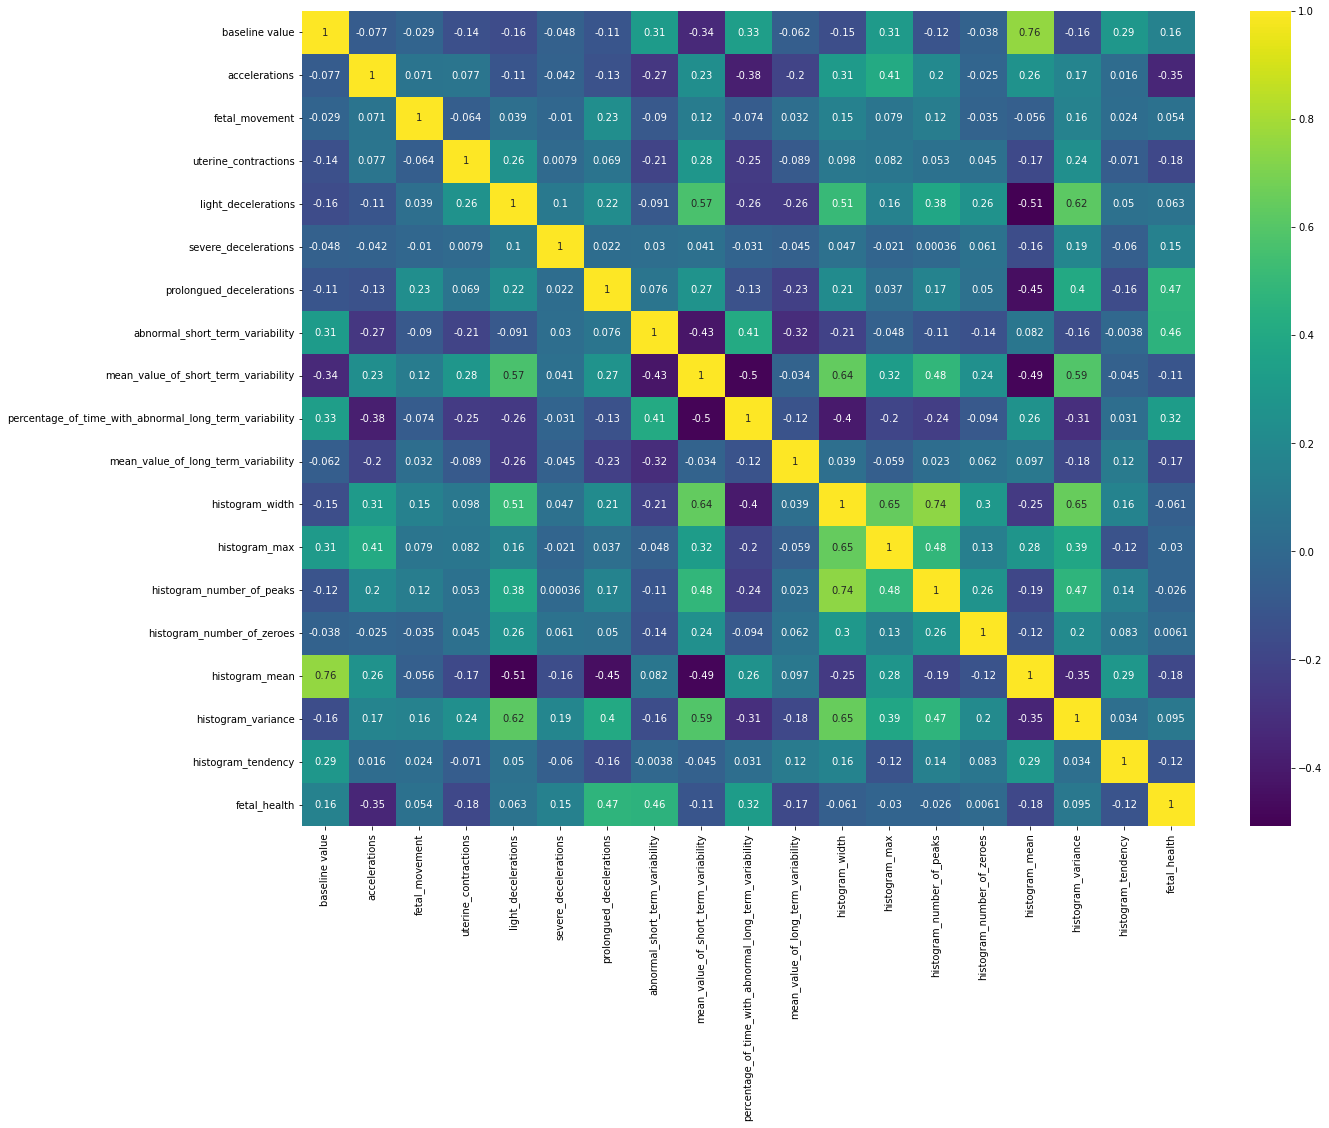

In [18]:
plt.figure(figsize=(20,15))
g = sns.heatmap(data_clean.corr(),annot = True, cmap='viridis')

## 2. Model Building

In [19]:
X = data_clean.drop('fetal_health', axis=1)
y = data_clean['fetal_health']

**Verify if the input features need scaling**

In [20]:
X.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mean,histogram_variance,histogram_tendency
count,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000
mean,133.229985,0.003273,0.008563,0.004420,0.001810,0.000003,0.000127,46.633860,1.269556,8.357471,8.052524,68.994901,163.499745,3.981642,0.305966,135.165732,15.708822,0.326364
std,9.923978,0.003878,0.044647,0.002888,0.002835,0.000055,0.000510,16.848986,0.732382,15.069337,4.817002,36.793827,17.158746,2.847245,0.632625,15.063084,20.401590,0.605724
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.000000,0.000000,8.000000,122.000000,0.000000,0.000000,76.000000,0.000000,-1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.000000,4.900000,37.000000,152.000000,2.000000,0.000000,125.000000,2.000000,0.000000
50%,133.000000,0.002000,0.000000,0.005000,0.000000,0.000000,0.000000,48.000000,1.200000,0.000000,7.500000,66.000000,161.000000,3.000000,0.000000,136.000000,7.000000,0.000000
75%,141.000000,0.006000,0.002000,0.007000,0.003000,0.000000,0.000000,60.000000,1.700000,10.000000,10.800000,98.000000,173.000000,6.000000,0.000000,146.000000,22.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,86.000000,3.900000,65.000000,24.700000,180.000000,238.000000,18.000000,7.000000,182.000000,101.000000,1.000000


***Conclusion:*** Clearly the there is a lot of variation on the input features and hence's scaling is needed

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [22]:
scaler = StandardScaler()

In [23]:
X_normalized = scaler.fit_transform(X)
X_normalized = pd.DataFrame(X_normalized, columns=list(X.columns))   

In [24]:
X_normalized.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mean,histogram_variance,histogram_tendency
0,-1.333473,-0.844302,-0.191841,-1.530558,-0.638515,-0.055399,-0.249137,1.565249,-1.051026,2.299462,-1.173752,-0.135788,-2.186017,-0.696163,-0.483769,0.121803,2.808889,1.112401
1,-0.123972,0.703300,-0.191841,0.547271,0.419919,-0.055399,-0.249137,-1.759241,1.134183,-0.554743,0.487456,1.658448,2.011164,0.709062,1.097349,0.055399,-0.181837,-0.538937
2,-0.023181,-0.070501,-0.191841,1.239881,0.419919,-0.055399,-0.249137,-1.818606,1.134183,-0.554743,1.110409,1.658448,2.011164,0.357756,1.097349,-0.011005,-0.132809,-0.538937
3,0.077611,-0.070501,-0.191841,1.239881,0.419919,-0.055399,-0.249137,-1.818606,1.543909,-0.554743,3.103858,1.305038,0.378927,2.465593,-0.483769,-0.077410,-0.132809,1.112401
4,-0.123972,0.961234,-0.191841,1.239881,-0.638515,-0.055399,-0.249137,-1.818606,1.543909,-0.554743,2.460140,1.305038,0.378927,1.762981,-0.483769,0.055399,-0.230865,1.112401


**Train-test Split**

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.25, random_state=101)

# ML Models

### 1. Multinomial Logistic Regression Model

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [28]:
log_model = LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state= 42)

In [29]:
log_model.fit(X_train,y_train)

LogisticRegression(multi_class='multinomial', random_state=42,
                   solver='newton-cg')

In [30]:
predictions = log_model.predict(X_test)

In [31]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.95      0.97      0.96       412
           2       0.79      0.72      0.75        57
           3       0.89      0.77      0.83        22

    accuracy                           0.93       491
   macro avg       0.88      0.82      0.85       491
weighted avg       0.93      0.93      0.93       491



In [32]:
scores = cross_val_score(log_model, X_normalized, y, cv = 10, scoring = 'accuracy')
print(scores.mean())

0.8781363306744018


**Conclusion:** *The initial evaluation suggests an accuracy of over 85% which is good. But it has a relatively poor recall rate for some classes 2(Suspect) and 3(Pathological), which is not ideal. We can try to identify if there's a scope to improve this model*

### Identify class-imbalance

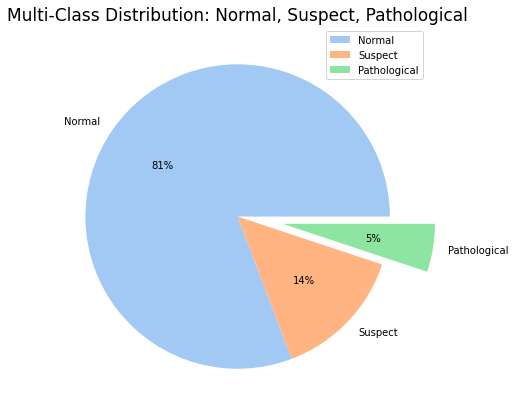

In [33]:
x_class = y.value_counts()
labels = ['Normal','Suspect','Pathological']
plt.get_cmap('hsv')
plt.figure(figsize = (14,7))
colors = sns.color_palette('pastel')[0:5]
plt.title('Multi-Class Distribution: Normal, Suspect, Pathological', fontsize = 17)
plt.pie(x_class, labels = labels, colors = colors, autopct='%.0f%%', explode=[0,0,.3])
plt.legend()
plt.show()

*There is a class imbalance of the target variable*

**Method:** We will use a novel oversampling technique called Synthetic Minority Oversampling Technique (SMOTE) developed by Nitesh Chawla, et al. (https://arxiv.org/abs/1106.1813).

Reference: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [34]:
import imblearn
from imblearn.over_sampling import SMOTE

In [35]:
oversample = SMOTE()

In [36]:
X_smote = X_normalized.copy()

In [37]:
X_smote, y_smote = oversample.fit_resample(X_smote, y)
#X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, test_size=0.25, random_state=101)

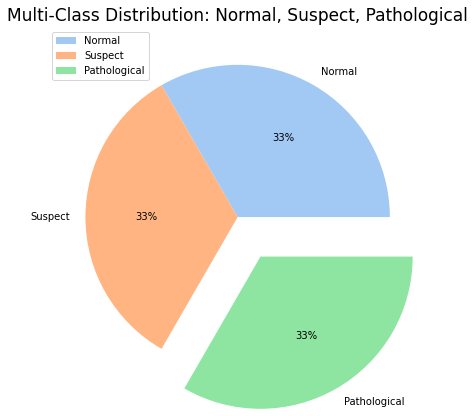

In [38]:
x_class = y_smote.value_counts()
labels = ['Normal','Suspect','Pathological']
plt.get_cmap('hsv')
plt.figure(figsize = (14,7))
colors = sns.color_palette('pastel')[0:5]
plt.title('Multi-Class Distribution: Normal, Suspect, Pathological', fontsize = 17)
plt.pie(x_class, labels = labels, colors = colors, autopct='%.0f%%', explode=[0,0,.3])
plt.legend()
plt.show()

The classes are perfectly balanced now

In [39]:
log_model.fit(X_smote,y_smote)
#log_model.fit(X_train,y_train)

LogisticRegression(multi_class='multinomial', random_state=42,
                   solver='newton-cg')

In [40]:
predictions = log_model.predict(X_test)

In [41]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.99      0.91      0.94       412
           2       0.62      0.95      0.75        57
           3       0.77      0.91      0.83        22

    accuracy                           0.91       491
   macro avg       0.79      0.92      0.84       491
weighted avg       0.93      0.91      0.92       491



In [42]:
scores = cross_val_score(log_model, X_train, y_train, cv = 10, scoring = 'accuracy')
print(scores.mean())

0.8986394557823129


**Conclusion:** The SMOTE oversampling technique resulted in the recall rates of minority class being exceptionally good compared to the imbalanced version

### 2. K-nearest Neighbors (KNN) classification

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
knn_model = KNeighborsClassifier(n_neighbors=4)
knn_model.fit(X_smote, y_smote)
#model_2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [45]:
predictions = knn_model.predict(X_test)

In [46]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       1.00      0.96      0.98       412
           2       0.77      0.98      0.86        57
           3       1.00      0.95      0.98        22

    accuracy                           0.96       491
   macro avg       0.92      0.97      0.94       491
weighted avg       0.97      0.96      0.97       491



In [47]:
scores = cross_val_score(knn_model, X_train, y_train, cv = 10, scoring = 'accuracy')
print(scores.mean())

0.9


**Conclusion:** The KNN classification on the multi-class performed better than Multinomial Logistic Regression model

### 3. Random Forest Decision Tree Model

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
forest_model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)

In [50]:
forest_model.fit(X_smote,y_smote)
#forest_model.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [51]:
predictions = forest_model.predict(X_test)

In [52]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       412
           2       0.98      0.98      0.98        57
           3       1.00      1.00      1.00        22

    accuracy                           1.00       491
   macro avg       0.99      0.99      0.99       491
weighted avg       1.00      1.00      1.00       491



**Conclusion:** The random forest decision tree performed extremely well with near perfect F1-score

In [53]:
scores = cross_val_score(forest_model, X_train, y_train, cv = 10, scoring = 'accuracy')
print(scores.mean())

0.9272108843537413


### 4. Support Vector Machine Classifier

In [54]:
from sklearn.svm import SVC
svm_model = SVC(kernel = 'rbf', C = 1).fit(X_smote, y_smote)
predictions = svm_model.predict(X_test)

In [55]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       1.00      0.91      0.95       412
           2       0.59      1.00      0.75        57
           3       1.00      1.00      1.00        22

    accuracy                           0.92       491
   macro avg       0.86      0.97      0.90       491
weighted avg       0.95      0.92      0.93       491



In [56]:
scores = cross_val_score(svm_model, X_train, y_train, cv = 10, scoring = 'accuracy')
print(scores.mean())

0.9068027210884354


**Conclusion:** The SVM classification performed extremely well with little hyperparameter tuning.

## 5. Neural Networks for Multinomial Classification

**The goal of building this neural network is to check how well a simple neural network performs for classification problems**

## Prepare Data

In [419]:
#Convert to numpy arrays
X_arr = X_smote.to_numpy()
y_arr = y_smote.to_numpy()

#Get the count of samples
m, n = X_arr.shape   #m - number of samples and n - number of features

#Split the data into training and test set
X_train_nn = X_arr[0:3564].T
y_train_nn = y_arr[0:3564]

X_test_nn = X_arr[3564:].T
y_test_nn = y_arr[3564:]

In [420]:
#One hot encode the labels
y_train_nn = one_hot(y_train_nn)

y_test_nn = one_hot(y_test_nn)

In [421]:
def one_hot(y):
    '''
    one hot encode the output labels
    '''
    
    one_hot_y = np.zeros((y.size, y.max()))
    one_hot_y[np.arange(y.size), y-1] = 1
    one_hot_y = one_hot_y.T
    
    return one_hot_y

## Activation functions


$ sigmoid(x) = \frac{1}{1 + e^{-x}}  $

$ relu(x) = max(0,x) $

$ tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}  $

$ softmax(i) = \frac{e^{z_i}}{\sum_{i=k}^ne^{z_k}}$

In [422]:
##Implementation of Activation functions
def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(x, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    expX = np.exp(x)
    return expX/np.sum(expX, axis = 0)

## Derivatives of activation functions

In [423]:
##derivative of the activation functions for GD
def derivative_tanh(x):
    return (1 - np.power(np.tanh(x), 2))

def derivative_relu(x):
    return np.array(x > 0, dtype = np.float32)

## Initialize random parameters 
$ W_1 = np.random.randn(n_1, n_0) $

$ b_1 = np.zeros((n_1, 1))$

$ W_2 = np.random.randn(n_2, n_1) $

$ b_2 = np.zeros((n_2, 1))$

In [424]:
def initialize_parameters(n_x, n_h, n_y):
    '''
    Initialize the weights and biases
    '''
    # Input - hidden layer
    w1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    
    # Hidden - Output layer
    
    w2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    
    #Capture the params
    parameters = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2
    }
    
    return parameters

## Forward Propagation 

$ Z_1 = W_1 * X + B_1 $

$ A_1 = f ( Z_1 ) $  

$ Z_2 = W2 * A_1 + B_2 $

$ A_2 = softmax( Z_2 ) $

In [425]:
def forward_propagation(x, parameters):
    '''
    forward propagation through the feed forward network
    '''
    
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    z1 = np.dot(w1, x) + b1
    
    #using relu since it performs well
    a1 = relu(z1)
    
    z2 = np.dot(w2, a1) + b2
    
    #using softmax because the output is multinomial
    a2 = softmax(z2)
    
    forward_cache = {
        "z1" : z1,
        "a1" : a1,
        "z2" : z2,
        "a2" : a2
    }
    
    return forward_cache

## Cost Function 

$Loss = - \sum_{i=k}^{n}[ y_k*log(a_k) ]$

$Cost = - \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{n}[ y_k*log(a_k) ]$

In [426]:
def cost_function(a2, y):
    '''
    Calculate cost of the softmax function 
    '''
    m = y.shape[1]
    
    cost = -(1/m)*np.sum(y*np.log(a2))
    
    return cost

## Backward Propagation
$dZ_2 = ( A_2 - Y )$

$ dW_2 = \frac{1}{m}. dZ_2 . A_1^T$

$ dB_2 = \frac{1}{m}.sum(dZ_2, 1)$



$dZ_1 = W_2^T . dZ_2 * f_1^|(Z_1) $

$dW_1 = \frac{1}{m}.dZ_1.X^T$

$dB_1 = \frac{1}{m}.sum(dZ_1, 1)$

In [427]:
def backward_prop(x, y, parameters, forward_cache):
    '''
    calculate the gradients of backward propagation
    '''
    
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    a1 = forward_cache['a1']
    a2 = forward_cache['a2']
    
    m = x.shape[1]
    
    dz2 = (a2 - y)
    dw2 = (1/m)*np.dot(dz2, a1.T)
    db2 = (1/m)*np.sum(dz2, axis = 1, keepdims = True)
    
    dz1 = (1/m)*np.dot(w2.T, dz2) * derivative_relu(a1)
    dw1 = (1/m)*np.dot(dz1, x.T)
    db1 = (1/m)*np.sum(dz1, axis = 1, keepdims = True)
    
    gradients = {
        "dw1" : dw1,
        "db1" : db1,
        "dw2" : dw2,
        "db2" : db2
    }
    
    return gradients

## Updating Parameters

$ W_2 = W_2 -  \alpha * \frac{\partial Cost }{\partial W_2}$ 

$ B_2 = B_2 -  \alpha * \frac{\partial Cost }{\partial B_2}$ 

$ W_1 = W_1 -  \alpha * \frac{\partial Cost }{\partial W_1}$ 

$ B_1 = B_1 -  \alpha * \frac{\partial Cost }{\partial B_1}$ 


In [428]:
def update_parameters(parameters, gradients, learning_rate):
    '''
    run the update rules on parameters
    '''
    
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    dw1 = gradients['dw1']
    db1 = gradients['db1']
    dw2 = gradients['dw2']
    db2 = gradients['db2']
    
    w1 = w1 - learning_rate*dw1
    b1 = b1 - learning_rate*db1
    w2 = w2 - learning_rate*dw2
    b2 = b2 - learning_rate*db2
    
    parameters = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2
    }
    
    return parameters

In [429]:
def model(x, y, n_h, learning_rate, iterations):
    '''
    batch gradient descent
    hyperparameters: learning rate, iterations
    '''
    
    n_x = x.shape[0]
    n_y = y.shape[0]
    
    cost_list = []
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    for i in range(iterations):
        
        forward_cache = forward_propagation(x, parameters)
        
        cost = cost_function(forward_cache['a2'], y)
        
        gradients = backward_prop(x, y, parameters, forward_cache)
        
        parameters = update_parameters(parameters, gradients, learning_rate)
        
        cost_list.append(cost)
        
        if(i%(iterations/10) == 0):
            print("Cost after", i, "iterations is :", cost)
        
    return parameters, cost_list

In [430]:
iterations = 10000
n_h = 50
learning_rate = 5
Parameters, Cost_list = model(X_train_nn, y_train_nn, n_h = n_h, learning_rate = learning_rate, iterations = iterations)

Cost after 0 iterations is : 1.098054774828771
Cost after 1000 iterations is : 0.19661043946358467
Cost after 2000 iterations is : 0.14816362126468038
Cost after 3000 iterations is : 0.11788067244844758
Cost after 4000 iterations is : 0.09830474061846559
Cost after 5000 iterations is : 0.08423199918196911
Cost after 6000 iterations is : 0.07386849265231826
Cost after 7000 iterations is : 0.06555915339859356
Cost after 8000 iterations is : 0.0589211081844391
Cost after 9000 iterations is : 0.05332620151691741


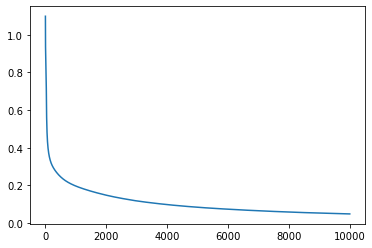

In [432]:
t = np.arange(0, iterations)
plt.plot(t, Cost_list)
plt.show()

### Evaluate the Model performance

In [448]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def accuracy(inp, labels, parameters):
    forward_cache = forward_propagation(inp, parameters)
    a_out = forward_cache['a2']   # containes propabilities with shape(10, 1)
    
    a_out = np.argmax(a_out, 0)  # 0 represents row wise 
    
    labels = np.argmax(labels, 0)
    
    acc = np.mean(a_out == labels)*100
    
    return acc

def prediction(inp, labels, parameters):
    forward_cache = forward_propagation(inp, parameters)
    a_out = forward_cache['a2']
    
    #find the index of max value (represents the predicted output class)
    a_out = np.argmax(a_out, 0)  # 0 represents row wise 
    
    
    #find the actual values
    labels = np.argmax(labels, 0)
    
    #find the accuracy
    acc = np.mean(a_out == labels)*100
    
    return labels, a_out

In [449]:
print("Accuracy of Train Dataset:", round(accuracy(X_train_nn, y_train_nn, Parameters), 2), "%")
print("Accuracy of Test Dataset:", round(accuracy(X_test_nn, y_test_nn, Parameters), 2), "%")

Accuracy of Train Dataset: 98.51 %
Accuracy of Test Dataset: 97.47 %


In [450]:
truth, pred = prediction(X_test, y_test, Parameters)

print('Confusion Matrix\n')
print(confusion_matrix(truth, pred))

Confusion Matrix

[[398  14   0]
 [  0  57   0]
 [  0   1  21]]


In [451]:
print('Classification Report\n')
print(classification_report(truth, pred))

Classification Report

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       412
           1       0.79      1.00      0.88        57
           2       1.00      0.95      0.98        22

    accuracy                           0.97       491
   macro avg       0.93      0.97      0.95       491
weighted avg       0.98      0.97      0.97       491

